#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold

## 1. Load Data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
combined_data = pd.concat([train_data,test_data],axis=0, ignore_index=True) #combined both train and test data
combined_data['Label'] = combined_data['SalePrice'].isnull() #new column 'label' on basis of 'SalePrice' column values
combined_data['Label'] = combined_data['Label'].map({False:'Train_data', True:'Test_data'})

## 2.Exploratory Data Analysis

#### 2.1 Train Data Exploration

In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_data.shape

(1460, 81)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
s1 = train_data.dtypes
s1.groupby(s1).count()

int64      35
float64     3
object     43
dtype: int64

In [8]:
#check null values in data
train_data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

#### 2.1 Test Data Exploration

In [9]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
test_data.shape

(1459, 80)

In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [12]:
s2 = test_data.dtypes
s2.groupby(s2).count()

int64      26
float64    11
object     43
dtype: int64

In [13]:
#check null values
test_data.isnull().sum().sort_values(ascending=False).head(34)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
TotalBsmtSF        1
Exterior2nd        1
GarageCars         1
Exterior1st        1
GarageArea         1
SaleType           1
MiscVal            0
dtype: int64

#### 2.3 Train & Test Data comparison

* We noticed that datatypes seems not to match in train data and test data

* Datatype comparison
* Null data comparison
* Distribution comparison

##### 1)Datatype Comparison

In [14]:
s1_train = s1.drop('SalePrice')
s1_train.compare(s2)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


In [15]:
test_data['GarageArea'].head()

0    730.0
1    312.0
2    482.0
3    470.0
4    506.0
Name: GarageArea, dtype: float64

In [16]:
train_data['GarageArea'].head()

0    548
1    460
2    608
3    642
4    836
Name: GarageArea, dtype: int64

##### 2)Null Values Comparison

In [17]:
null_train = train_data.isnull().sum()
null_test = test_data.isnull().sum()
null_train = null_train.drop('SalePrice')
null_train.compare(null_test).sort_values(['self','other'],ascending=[False,False])

,self,other
PoolQC,1453.0,1456.0
MiscFeature,1406.0,1408.0
Alley,1369.0,1352.0
Fence,1179.0,1169.0
FireplaceQu,690.0,730.0
LotFrontage,259.0,227.0
GarageYrBlt,81.0,78.0
GarageFinish,81.0,78.0
GarageQual,81.0,78.0
GarageCond,81.0,78.0


In [18]:
#below features have most missing values so we can drop this features
null_train.compare(null_test).sort_values(['self','other'],ascending=[False,False]).index[0:4]

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')

##### 3)Data Distribution Comparison

In [19]:
#Data distribution comparison - continuos variables
con_var = s1[s1.values != 'object'].index

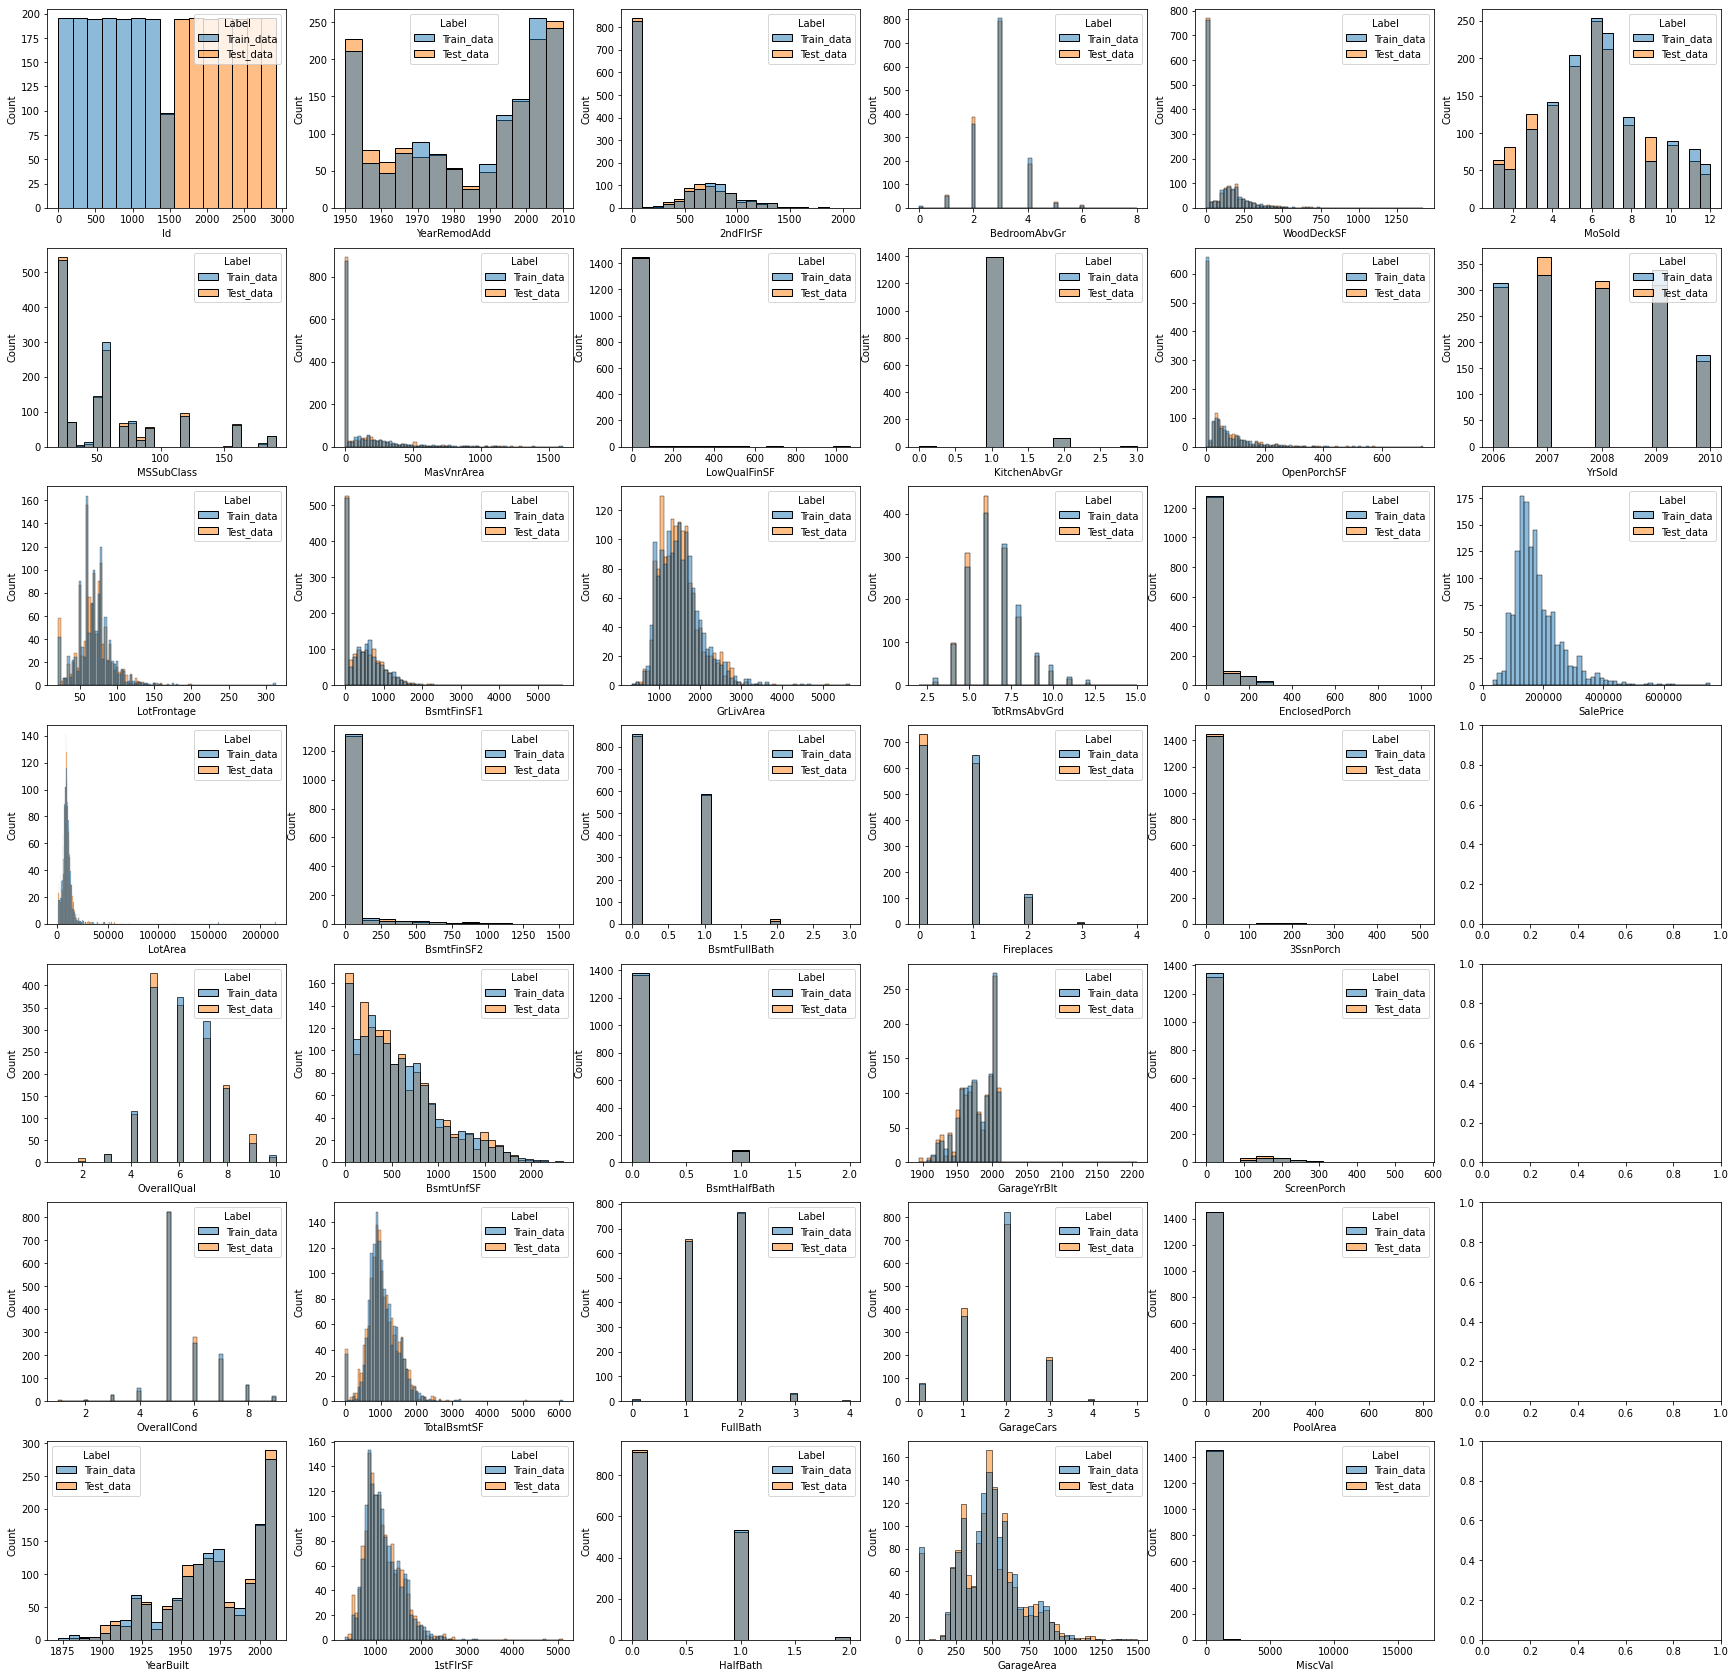

In [20]:
fig, axes = plt.subplots(7,6,figsize=(30,30))
for i, feature in enumerate(con_var):
    sns.histplot(data=combined_data,x=feature,hue='Label',ax=axes[i%7,i//7])

Conclusion:
   * Distrubution for train and test data looks similar for continous features
   * some features can be classified as categorical features
   * some features are dominated by null so can be dropped

In [ ]:
#linearity between features and target feature
fig, ax = plt.subplots(10,4,figsize=(30,60))

for i, feature in enumerate(con_var):
    sns.scatterplot(data=train_data,x=feature,y='SalePrice',ax=ax[i%10,i//10])

Here we can see some correlation are positive but quite linear
 * 'SalePrice' VS.'BsmtUnfSF'
 * 'SalePrice' VS.'LotFrontage'
 * 'SalePrice' VS.'LotArea'
 * 'SalePrice' VS.'1stFlrSF'
 * 'SalePrice' VS.'GrLivArea'
 * 'SalePrice' VS.'TotalBsmtSF'
 * 'SalePrice' VS.'GarageArea'
 
so we will consider such features transform into log forms

In [ ]:
#Data distribution comparison - categorical variables

cat_var = s1[s1.values == 'object'].index

fig, ax = plt.subplots(8,6,figsize=(30,30))

for i, feature in enumerate(cat_var):
    sns.countplot(data=combined_data,x=feature,hue='Label',ax=ax[i%8,i//8])

* Train & Test data distribution in same for most of the features
* some features have dominant items, we can consider clubing some minor items such as 'Fa' & 'Po' in
'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond'

we also want to confirm that the items we want to combine has similar price

In [ ]:
club_var =['HeatingQC','FireplaceQu','GarageQual','GarageCond']

fig, ax = plt.subplots(2,2,figsize=(10,10))

for i,feature in enumerate(club_var):
    sns.boxplot(data=train_data,x=feature,y='SalePrice',ax=ax[i%2,i//2])

Here, we could see that sale prices for 'Fa' & 'Po' in 'HeatingQC', 'FireplaceQu', 'GarageQual' and 'GarageCond' are similar, so we may consider go ahead and combine the items.

#### 2.4 Data Correlation

In [ ]:
con_data= train_data.copy()

for col in cat_var:
    con_data=con_data.drop(col,axis=1)
    
training_corr = con_data.corr(method='spearman')
mask = np.zeros_like(training_corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,10))
sns.heatmap(training_corr, mask=mask,cmap='YlGnBu',linewidths=0.5)

Feature like 'OverallQual', 'GrlivArea', 'GarageCars' are highly correlated to SalePrice.

In [ ]:
# top 10 correlated features vs. saleprice
correlations = con_data.corr(method='spearman')['SalePrice'].sort_values(ascending=False)
correlations_abs = correlations.abs()
print(correlations_abs.head(11))

## 3. Feature Engineering

In [ ]:
def pre_process(train_data, test_data, fillna_dict={}, drop_list=[], convert_list=[], log_list=[], regroup_dict={}):
    combined_data = pd.concat([train_data,test_data],ignore_index=True,axis=0)
    
    #step1:filling missing values
    for col, fill_value in fillna_dict.items():
        combined_data[col] = combined_data[col].fillna(value=fill_value)
        
    #step3:drop columns
    combined_data.drop(columns=drop_list, inplace=True, errors='ignore')
    
    #step3: convert numerical features into categorical
    for col in convert_list:
        combined_data[col]=combined_data[col].astype('str')
        
    #step4: apply power transformer to few columns
    for col in log_list:
        log = PowerTransformer()
        log.fit(train_data[[col]])
        combined_data[col] = log.transform(combined_data[[col]])
        
        
        
    #step5: regroup features
    for col, regroup_val in regroup_dict.items():
        mask = combined_data[col].isin(regroup_val)
        combined_data[col][mask] = 'Other'
    
#     #step6: drop categorical columns with absolute dominating value for i in combined data columns
    for i in combined_data.columns:
        if combined_data[i].dtype != 'object':
            continue
        counts = combined_data[i].value_counts()
        zeros = counts.iloc[0]
        if zeros/len(combined_data)>0.995:
            print(f'Feature {combined_data[i].name} value {counts.index[0]} is dominating with percentage {zeros/len(combined_data)},dropping the feature')
            combined_data.drop(columns=combined_data[i].name, inplace=True, errors= 'ignore')
            
#     #step7: add features
    combined_data['Total_Home_Quality'] = combined_data['OverallQual'] + combined_data['OverallCond']
    combined_data['Total_bathrooms'] = (combined_data['FullBath']+(0.5*combined_data['HalfBath'])+
                                       combined_data['BsmtFullBath']+(0.5*combined_data['BsmtHalfBath']))
    combined_data['HighQualSF'] = combined_data['1stFlrSF'] + combined_data['2ndFlrSF']
    combined_data['Total_square_footage'] = (combined_data['BsmtFinSF1']+combined_data['BsmtFinSF2'] +
                                            combined_data['1stFlrSF']+combined_data['2ndFlrSF'])
    
#     #step: generate one-hot dummy columns 
    combined_data =pd.get_dummies(combined_data).reset_index(drop=True)
    
    new_train_data = combined_data.iloc[:len(train_data),:]
    new_test_data = combined_data.iloc[len(train_data):,:]
    X_train = new_train_data.drop('SalePrice', axis=1)
    y_train = np.log1p(new_train_data['SalePrice'].values.ravel())
    X_test = new_test_data.drop('SalePrice',axis=1)
    
    return X_train, y_train, X_test

In [ ]:
fillna_dict={
    'PoolQC':'NA','MiscFeature':'NA', 'Alley':'NA', 'Fence':'NA', 'FireplaceQu':'NA',
    'LotFrontage':train_data['LotFrontage'].mean(),'GarageYrBlt':0.0, 'GarageFinish':'NA',
    'GarageQual':'NA','GarageCond':'NA','GarageType':'NA','BsmtExposure':'NA','BsmtFinType2':'NA',
    'BsmtCond':'NA','BsmtQual':'NA','BsmtFinType1':'NA','MasVnrType':'None','MasVnrArea':0.0,
    'MSZoning':train_data['MSZoning'].mode()[0],'BsmtFullBath':0.0,'BsmtHalfBath':0.0,'BsmtFinSF1':0.0,
    'BsmtFinSF2':0.0,'BsmtUnfSF':0.0, 'TotalBsmtSF':0.0,'GarageCars':0.0, 'GarageArea':0.0}

drop_list=['Id']

conver_to_str_list=['MSSubClass']

log_list = ['BsmtUnfSF', 'LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea','TotalBsmtSF', 'GarageArea']

regroup_dict={'HeatingQC':['Fa','Po'],'FireplaceQu':['Fa','Po'],'GarageQual':['Fa','Po'],'GarageCond':['Fa','Po'],
             'LotConfig': ['FR2','FR3'],'LandSlope':['Mod','Sev'],'BldgType':['2FmCon','Duplex'],
              'RoofStyle':['Mansard','Flat','Gambrel'],'Electrical':['FuseF','FuseP','FuseA','Mix'],
              'SaleCondition':['Abnorml','AdjLand','Alloca','Family'],'BsmtExposure':['Min','Av'],
              'Functional':['Min1','Maj1','Min2','Mod','Maj2','Sev'],'LotShape':['IR2','IR3'],}

In [ ]:
X,y,X_test = pre_process(train_data,test_data,
                        fillna_dict=fillna_dict,
                        drop_list=drop_list,
                        convert_list=conver_to_str_list,
                        log_list=log_list,
                        regroup_dict=regroup_dict)
print(X.shape)

pre_precessing_pipeline = make_pipeline(RobustScaler(), 
                                        # VarianceThreshold(0.001),
                                       )

X = pre_precessing_pipeline.fit_transform(X)
X_test = pre_precessing_pipeline.transform(X_test)

print(X.shape)
print(X_test.shape)